<a href="https://colab.research.google.com/github/DanaKailani/VideoCaptioning/blob/main/VideoCaptioning_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras import Input

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import cv2
import sys
import time
import math
import datetime


START = "startseq"
STOP = "endseq"
EPOCHS = 50

os.chdir('/content/drive/My Drive')
!pwd

/content/drive/My Drive


In [ ]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [ ]:
root_captioning = "/content/drive/My Drive/Flickr_Data/Flickr_Data"

In [ ]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr_TextData','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [ ]:
img = glob.glob(os.path.join('/content/drive/My Drive/Flickr_Data/Flickr_Data','Images', '*.jpg'))

In [ ]:
train_images_path = os.path.join(root_captioning,'Flickr_TextData','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr_TextData','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [ ]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [ ]:
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

In [ ]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [ ]:
train_path ='/content/drive/My Drive/Flickr_Data/Flickr_Data/ModelData/train2048.pkl'
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join('/content/drive/My Drive/Flickr_Data/Flickr_Data','Images', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

In [ ]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [ ]:
max_length +=2

In [ ]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [ ]:
glove_dir = '/content/drive/My Drive/Flickr_Data/Flickr_Data/glove'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

400000it [00:17, 22595.19it/s]


In [ ]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model_path = '/content/drive/My Drive/Flickr_Data/Flickr_Data/ModelData/caption-model.hdf5'
new_path = os.path.join('/content/drive/My Drive/Flickr_Data/Flickr_Data/ModelData',f'caption-model.hdf5')
if not os.path.exists(model_path):
  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 10
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(new_path)
else:
  caption_model.load_weights(model_path)

In [ ]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
test_path = '/content/drive/My Drive/Flickr_Data/Flickr_Data/ModelData/test2048.pkl'
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join('/content/drive/My Drive/Flickr_Data/Flickr_Data','Images', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1056338697_4f7d7ce270.jpg


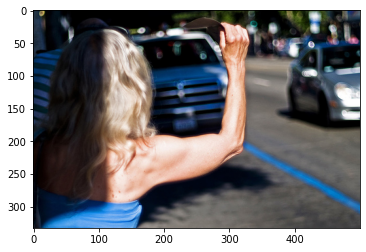

Caption: man in black shirt and jeans is standing on the sidewalk with sunglasses
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/106490881_5a2dd9b7bd.jpg


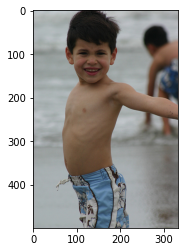

Caption: young girl in pink swimsuit is standing in the water
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1082379191_ec1e53f996.jpg


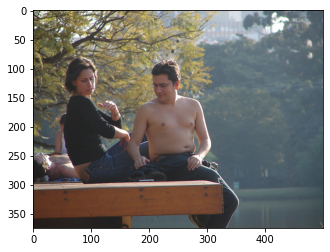

Caption: man in blue shirt is sitting on bench
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1084040636_97d9633581.jpg


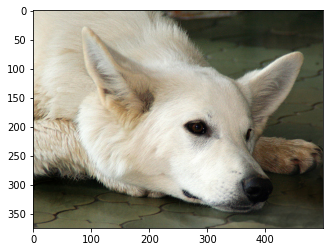

Caption: dog is running away from the edge of snow dune
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1096395242_fc69f0ae5a.jpg


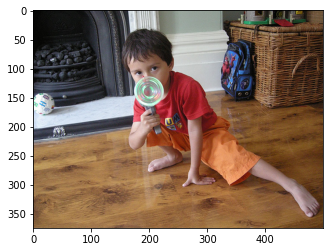

Caption: little boy in blue shirt is standing on the bed
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1107246521_d16a476380.jpg


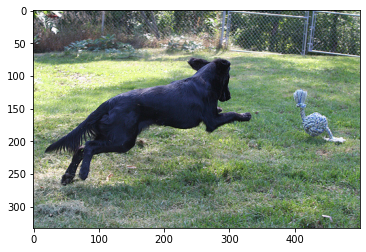

Caption: black dog is running in the grass with pink purse in its mouth
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1119015538_e8e796281e.jpg


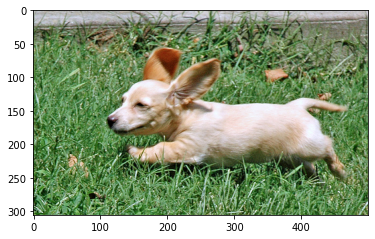

Caption: brown dog is running through green grass
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1122944218_8eb3607403.jpg


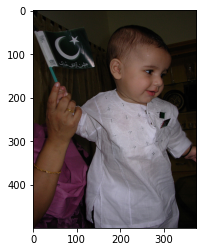

Caption: young girl with curly hair is smiling with the sun behind her
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1131800850_89c7ffd477.jpg


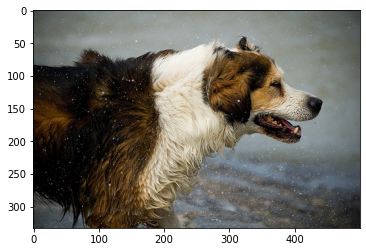

Caption: dog swims in the water
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1131932671_c8d17751b3.jpg


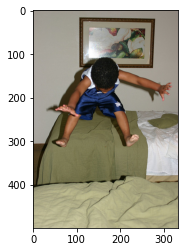

Caption: little boy in camouflage crawls on floor with pillow
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/113678030_87a6a6e42e.jpg


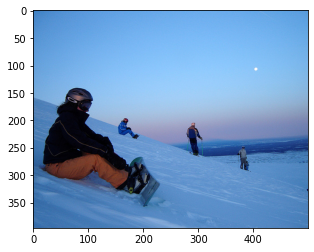

Caption: two people are in the snow
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/114051287_dd85625a04.jpg


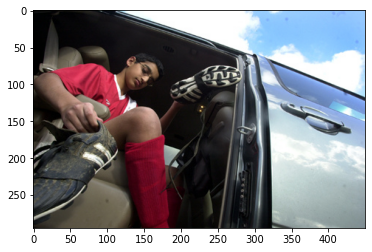

Caption: man in black hat and hat is sitting on bench
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/115684808_cb01227802.jpg


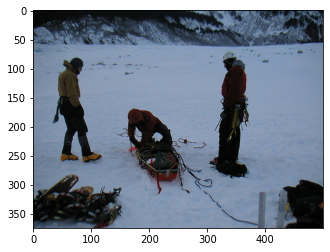

Caption: two people are standing on snow covered ground overlooking the mountains
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1167669558_87a8a467d6.jpg


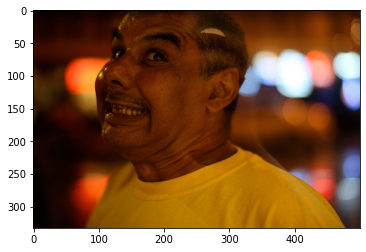

Caption: man with beard and woman wearing black and white shirt
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1174525839_7c1e6cfa86.jpg


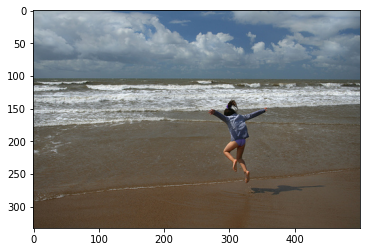

Caption: girl in red bathing suit jumping in the sand at dusk
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1174629344_a2e1a2bdbf.jpg


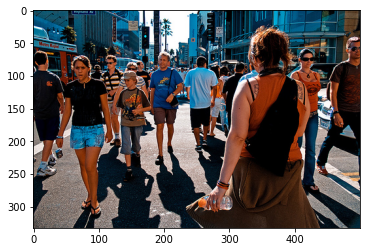

Caption: group of people walking down the street
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1220401002_3f44b1f3f7.jpg


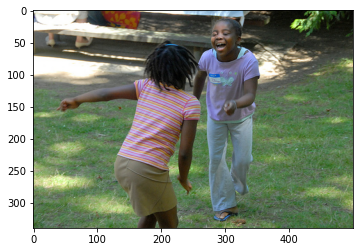

Caption: two children are bouncing on trampoline
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1224851143_33bcdd299c.jpg


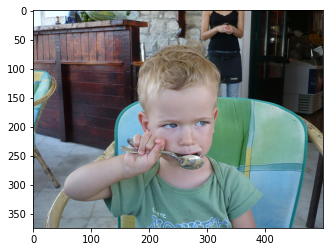

Caption: little girl in pink dress lays on the of green slide
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1237985362_dbafc59280.jpg


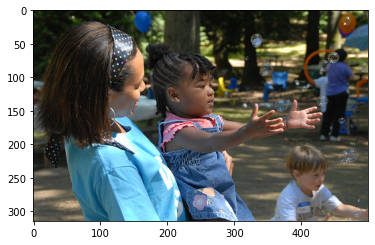

Caption: two girls in colourful dresses hold hands and smile
_____________________________________
/content/drive/My Drive/Flickr_Data/Flickr_Data/Images/1248940539_46d33ed487.jpg


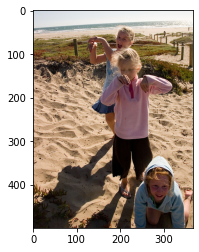

Caption: man and woman walk on the beach
_____________________________________


In [ ]:
for z in range(20):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join('/content/drive/My Drive/Flickr_Data/Flickr_Data','Images', pic))
  x=plt.imread(os.path.join('/content/drive/My Drive/Flickr_Data/Flickr_Data','Images', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

Video has been read successfully!
Total Frames: 1518
Width: 640
Height: 360
Frames per Second: 24.901574803149607


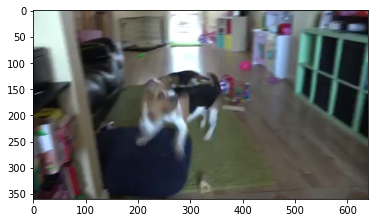

Caption: two dogs are playing in the grass
_________________________________________________


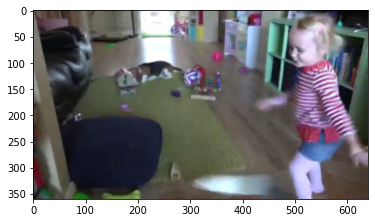

Caption: two girls are sitting on the floor with legs on their ears
_________________________________________________


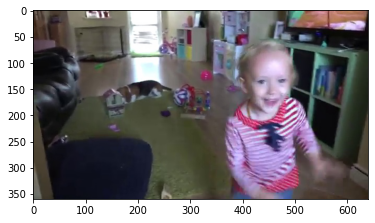

Caption: two young boys are playing with box of
_________________________________________________


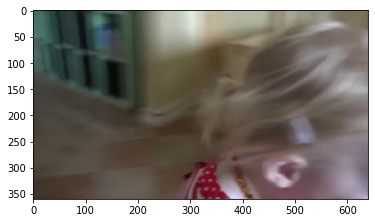

Caption: woman in red shirt and black shirt her head on her back
_________________________________________________


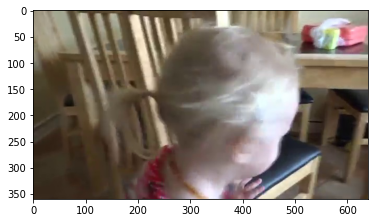

Caption: man in black shirt and gold hat is talking to woman in white suit
_________________________________________________


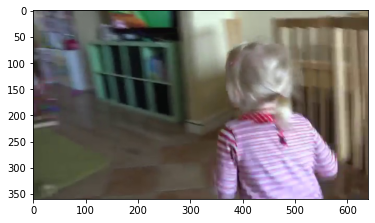

Caption: two girls are sitting on bench
_________________________________________________


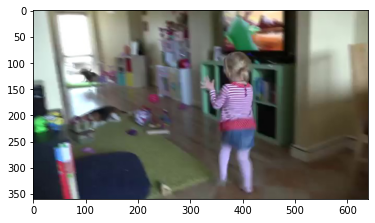

Caption: two girls are sitting on the floor and smiling
_________________________________________________


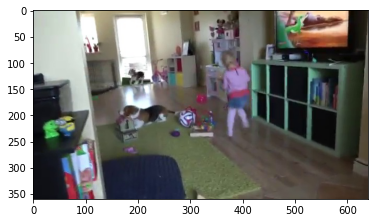

Caption: two girls are sitting on an ride park ride
_________________________________________________


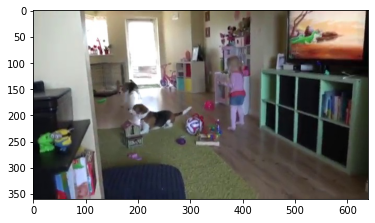

Caption: two women are sitting on bench
_________________________________________________


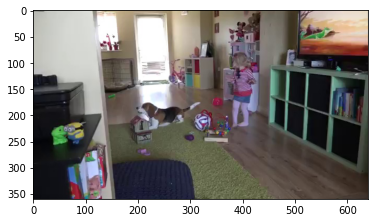

Caption: two children are sitting on bench
_________________________________________________


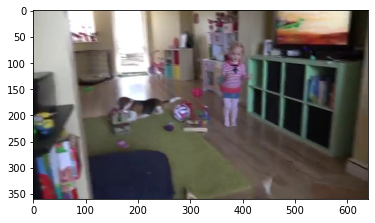

Caption: two women are sitting on bench
_________________________________________________


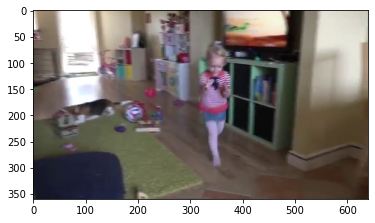

Caption: two girls are sitting on the floor and smiling
_________________________________________________


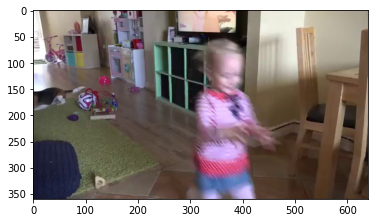

Caption: two girls are sitting on the floor and smiling
_________________________________________________


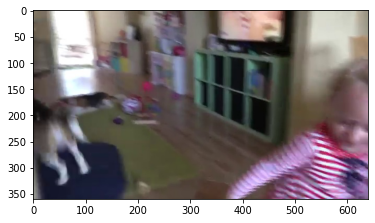

Caption: two girls are sitting on bar one of which is holding
_________________________________________________


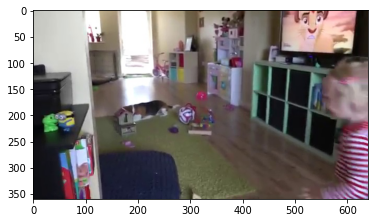

In [ ]:
filename = r'/content/drive/My Drive/Videos/Little Girl Playing with Her Puppy  Cute Dog Playing with Child.mp4'


def prepare(img):
    image = tensorflow.keras.preprocessing.image.load_img(img)
    image = encodeImage(image)
    image = image.reshape((1,OUTPUT_DIM))
    return image


# Converting digital data to binary format
#def convertToBinaryData(image):
    #with open(image, 'rb') as img:
        #binaryData = img.read()
    #return binaryData


# Capture the video
cap = cv2.VideoCapture(filename)

# Check if capture was successful
if not cap.isOpened():

    print("The video could not open!")

    sys.exit

else:

    print("Video has been read successfully!")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fps = cap.get(cv2.CAP_PROP_FPS)

    print('Total Frames: ' + str(total_frames))
    print('Width: ' + str(width))
    print('Height: ' + str(height))
    print('Frames per Second: ' + str(fps))

    seconds = math.floor(total_frames/fps)

    start = time.time()

    cap = cv2.VideoCapture(filename)

    for i in range(total_frames+1):

      if(i % 20 == 0):

        cap.set(1,i)

        success = cap.grab()

        # Grabs the next frame from the video file or capturing device.

        ret, image = cap.retrieve()

        name = '/content/drive/My Drive/Video Frames/image'+str(int((i/20)))+'.jpg'

        cv2.imwrite(name, image)

        end = time.time()

        resizedImage = prepare(name)

        img = plt.imread(name)

        plt.imshow(img)

        plt.show()

        caption = generateCaption(resizedImage)

        print("Caption: " + caption)

        print("_________________________________________________")

# print("The total time taken is : " + str(end - start) + " seconds")